In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
def linear_law(x, a, b):
    return a*x+b

def power_law(x, a, b, c):
    return (x**a)*b + c

def curve_fit_power_law(xdata, ydata, type = "linear"):
    if type == "linear":
        log_xdata = np.log(xdata)
        log_ydata = np.log(ydata)
        popt, pcov = curve_fit(linear_law, log_xdata, log_ydata)
        perr = np.sqrt(np.diag(pcov))
        yfit = np.exp(linear_law(log_xdata, *popt))
        return yfit, popt, perr

    if type == "power":
        popt, pcov = curve_fit(power_law, xdata, ydata)
        perr = np.sqrt(np.diag(pcov))
        return power_law(xdata,*popt), popt, perr
    return ValueError("Shit")

In [4]:
foldername = "../SimResults/"
df = pd.read_csv("../SimResults/sim_9.99e-01r0_800L_31seed.csv")

FileNotFoundError: File b'../SimResults/sim_1.10e+00r0_800L_31seed.csv' does not exist

In [79]:
df.head()

,t,num_active_sites,N,h_mean,h_std,trans_len,paral_len,density_last_interval,empty_bond_mass,empty_bond_volume,mean_bond_size
0,0.365739,0,1,0.00125,0.035333,1,1,0.0000,0.0,0.0,0.0
1,0.365739,0,2,0.00250,0.049937,1,1,0.0005,NaN,NaN,NaN


In [87]:
name_list = []
r0_list_full = [0.1, 0.5, 0.7, 0.9, 0.99, 0.999, 0.9999, 1, 1.001, 1.01, 1.1]
r0_list = r0_list_full[2:7]
delta_list = [np.abs(np.exp(-r) - np.exp(-1)) for r in r0_list]
dom_list_full = [200, 400, 800]
dom_list = dom_list_full[:3]

max_survival_times_dom = []
transverse_length_dom = []
paral_length_dom = []

for dom in dom_list:
    max_survival_times_single_dom = np.zeros((len(r0_list), 2))
    transverse_length_single_dom = np.zeros((len(r0_list), 2))
    parallel_length_single_dom = np.zeros((len(r0_list), 2))

    for r, r_0 in enumerate(r0_list):
        exit_times = np.zeros(32)
        trans_len = np.zeros(32)
        paral_len = np.zeros(32)
        for i, seed in enumerate(range(32)):
            csv_name = '../SimResults/'+ 'sim_%.5er0_%dL_%dseed.csv'%(r_0, dom, seed)
            try:
                df = pd.read_csv(csv_name)
                exit_times[i] = df["t"].iloc[-1]
                trans_len[i] = df[" trans_len"].iloc[-1]
                paral_len[i] = df[" paral_len"].iloc[-1]
            except FileNotFoundError:
                exit_times[i] = np.NaN

            except KeyError:
                try:
                    df = pd.read_csv(csv_name)
                    exit_times[i] = df["t"].iloc[-1]
                    trans_len[i] = df["trans_len"].iloc[-1]
                    paral_len[i] = df["paral_len"].iloc[-1]
                except KeyError:
                    print("How did you fuck up this bad??")
        
        max_survival_times_single_dom[r, 0] = np.mean(exit_times)
        max_survival_times_single_dom[r, 1] = np.std(exit_times)
        transverse_length_single_dom[r, 0] = np.mean(trans_len)
        transverse_length_single_dom[r, 1] = np.std(trans_len)
        parallel_length_single_dom[r, 0] = np.mean(paral_len)
        parallel_length_single_dom[r, 1] = np.std(paral_len)
        
    max_survival_times_dom.append(max_survival_times_single_dom)
    transverse_length_dom.append(transverse_length_single_dom)
    paral_length_dom.append(parallel_length_single_dom)


In [88]:
max_survival_times = np.array(max_survival_times_dom)
transverse_length = np.array(transverse_length_dom)
paral_length = np.array(paral_length_dom)

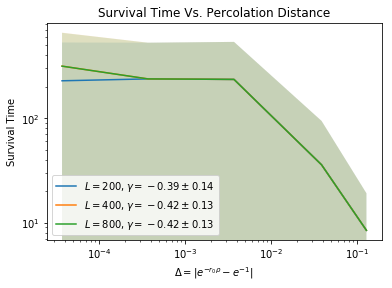

In [130]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    ydata = max_survival_times[i, :, 0]
    ydata_std = max_survival_times[i, :, 1]
    yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
    exp = popt[0]
    exp_err = perr[0]

    # plt.plot(xdata, yfit)
    plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.15)
    plt.plot(xdata, ydata, label = rf"$L = {length}, \gamma = {exp:.2f} \pm {exp_err:.2f}$")

plt.title("Survival Time Vs. Percolation Distance")
plt.xlabel(r"$\Delta = |e^{-r_0\rho} - e^{-1}|$")
plt.ylabel("Survival Time")
plt.xscale("log")
plt.yscale("log")
plt.legend()

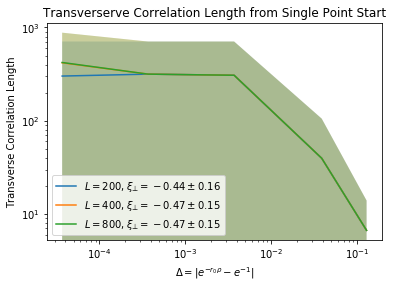

In [141]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    ydata = transverse_length[i, :, 0]
    ydata_std = transverse_length[i, :, 1]
    yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
    exp = popt[0]
    exp_err = perr[0]
    
    # plt.plot(xdata, yfit)
    plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
    plt.plot(xdata, ydata, label = rf"$L = {length}, \xi_\bot = {exp:.2f} \pm {exp_err:.2f}$")

plt.title("Transverserve Correlation Length from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\rho} - e^{-1}|$")
plt.ylabel("Transverse Correlation Length")
plt.xscale("log")
plt.yscale("log")
plt.legend()

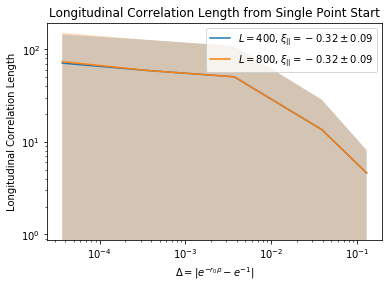

In [147]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    try:
        ydata = paral_length[i, :, 0]
        ydata_std = paral_length[i, :, 1]
        yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
        exp = popt[0]
        exp_err = perr[0]
        
        # plt.plot(xdata, yfit)
        plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
        plt.plot(xdata, ydata, label = f"$L = {length}," + r"\xi_{||}$" + f"$ = {exp:.2f} \pm {exp_err:.2f}$")
    except ValueError:
        continue

plt.title("Longitudinal Correlation Length from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\rho} - e^{-1}|$")
plt.ylabel("Longitudinal Correlation Length")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [120]:
yfit

array([40.33749995, 40.33749995, 40.33749995, 40.33749995, 40.33749995])

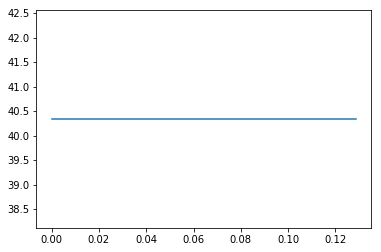

In [119]:
plt.figure()
plt.plot(xdata, yfit)

In [110]:
df[" empty_bond_mass"]

0    0.0
1    NaN
Name:  empty_bond_mass, dtype: float64

In [105]:
name_list = []
r0_list_full = [0.1, 0.5, 0.7, 0.9, 0.99, 0.999, 0.9999, 1, 1.001, 1.01, 1.1]
r0_list = r0_list_full[2:7]
delta_list = [np.abs(np.exp(-r) - np.exp(-1)) for r in r0_list]
dom_list = [200, 400, 800]

Masses_dom = []
Volumes_dom = []
Sizes_dom = []

for dom in dom_list:
    M_single_dom = np.zeros((len(r0_list), 2))
    V_single_dom = np.zeros((len(r0_list), 2))
    S_single_dom = np.zeros((len(r0_list), 2))

    for r, r_0 in enumerate(r0_list):
        M = np.zeros(32)
        V = np.zeros(32)
        S = np.zeros(32)
        for i, seed in enumerate(range(32)):
            csv_name = '../SimResults/'+ 'sim_%.2er0_%dL_%dseed.csv'%(r_0, dom, seed)
            try:
                df = pd.read_csv(csv_name)
                M[i] = df["empty_bond_mass"].iloc[-1]
                V[i] = df["empty_bond_volume"].iloc[-1]
                S[i] = df["empty_bond_size"].iloc[-1]
            except FileNotFoundError:
                M[i] = np.NaN
                V[i] = np.NaN
                S[i] = np.NaN
            except KeyError:
                try:
                    df = pd.read_csv(csv_name)
                    M[i] = df[" empty_bond_mass"].iloc[-1]
                    V[i] = df[" empty_bond_volume"].iloc[-1]
                    S[i] = df[" empty_bond_size"].iloc[-1]
                except KeyError:
                    M[i] = np.NaN
                    V[i] = np.NaN
                    S[i] = np.NaN
                    print("How did you fuck this up?", f"r0: {r_0}|   seed: {i}")
                    continue
        
        M_single_dom[r, 0] = np.mean(exit_times)
        M_single_dom[r, 1] = np.std(exit_times)
        V_single_dom[r, 0] = np.mean(trans_len)
        V_single_dom[r, 1] = np.std(trans_len)
        S_single_dom[r, 0] = np.mean(paral_len)
        S_single_dom[r, 1] = np.std(paral_len)
        
    Masses_dom.append(M_single_dom)
    Volumes_dom.append(V_single_dom)
    Sizes_dom.append(S_single_dom)

Masses = np.array(Masses_dom).squeeze()
Volumes = np.array(Volumes_dom).squeeze()
Sizes = np.array(Sizes_dom).squeeze()


How did you fuck this up? r0: 0.7|   seed: 0
How did you fuck this up? r0: 0.7|   seed: 1
How did you fuck this up? r0: 0.7|   seed: 2
How did you fuck this up? r0: 0.7|   seed: 3
How did you fuck this up? r0: 0.7|   seed: 4
How did you fuck this up? r0: 0.7|   seed: 5
How did you fuck this up? r0: 0.7|   seed: 6
How did you fuck this up? r0: 0.7|   seed: 7
How did you fuck this up? r0: 0.7|   seed: 8
How did you fuck this up? r0: 0.7|   seed: 9
How did you fuck this up? r0: 0.7|   seed: 10
How did you fuck this up? r0: 0.7|   seed: 11
How did you fuck this up? r0: 0.7|   seed: 12
How did you fuck this up? r0: 0.7|   seed: 13
How did you fuck this up? r0: 0.7|   seed: 14
How did you fuck this up? r0: 0.7|   seed: 15
How did you fuck this up? r0: 0.7|   seed: 16
How did you fuck this up? r0: 0.7|   seed: 17
How did you fuck this up? r0: 0.7|   seed: 18
How did you fuck this up? r0: 0.7|   seed: 19
How did you fuck this up? r0: 0.7|   seed: 20
How did you fuck this up? r0: 0.7|   seed: 2

In [106]:
df[" empty_bond_mass"].iloc[-1]

nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


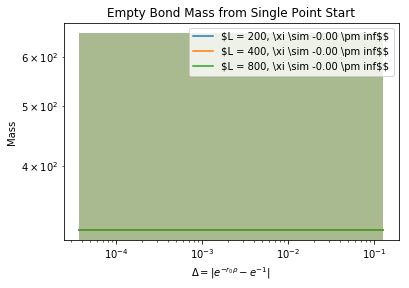

In [112]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    try:
        ydata = Masses[i, :, 0]
        ydata_std = Masses[i, :, 1]
        yfit, popt, perr = curve_fit_power_law(xdata, ydata)
        exp = popt[0]
        exp_err = perr[0]
        
        # plt.plot(xdata, yfit)
        plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
        plt.plot(xdata, ydata, label = rf"$L = {length}, \xi \sim {exp/1000:.2f} \pm {exp_err:.2f}$$")
    except ValueError:
        continue

plt.title("Empty Bond Mass from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\rho} - e^{-1}|$")
plt.ylabel("Mass")
plt.xscale("log")
plt.yscale("log")
plt.legend()